# profile likelihood scans in 3D

In this notebook, a scan over parameters is done while profiling the NLL function.  This is useful to visualize the contours of the NLL about it's optimal (minimum) values.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.ndimage import zoom
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 42981,
  "iopub_port": 42057,
  "stdin_port": 38261,
  "control_port": 52721,
  "hb_port": 56013,
  "ip": "127.0.0.1",
  "key": "a7b4a15f-f0febb49729417bde8a27a86",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a62813e7-abd6-46ad-b88a-ea4342c94d51.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/nominal/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()
asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

In [3]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [8, 8, 8]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [ ]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-2, 
                   disp=True
                  )

# initial config
mask = fit_data._pmask.copy()
mask[:4] = True
fit_data._pmask[:4] = False
pinit = params_pre[fit_data._pmask]
sample = asimov_data

#for category in fit_data._categories:
#    val, var = fit_data.mixture_model(sv, category)
#    sample[category] = [np.random.poisson(val), val]

results = []
cost = []
sv_accept = []
for sv in tqdm_notebook(scan_vals):
    
    ## randomize n.p.
    #pinit = params_pre[fit_data._pmask]
    #mask[:4] = False
    #np_random = pinit[4:] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    #fit_data._pval_init[mask] = np_random
    ##sv[mask] = np_random
    #mask[:4] = True
    
    ## generate data from scan values w/ statistical variation
    
    # fix values for the W branching fractions
    fit_data._pval_init[:4] = sv[:4]

    # carry out minimization
    result = minimize(fit_data.objective, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fit_data.objective_jacobian,
                      args    = (sample)
                     )
    pinit = result.x
    print('', result.success, fit_data.objective(pinit), fit_data.objective(sv[fit_data._pmask]), result.fun)
    print(' scan vals: ', sv[:4])
    #print(' fit vals:', result.x[:4], end='\n\n')

    sv_accept.append(sv[mask])
    results.append(result.x)
    cost.append(result.fun)
    
sv_accept = np.array(sv_accept)
results = np.array(results)
cost = np.array(cost)

         Current function value: 18.520431
         Iterations: 51
         Function evaluations: 126
         Gradient evaluations: 116
 False 1057.7235516237938 1704.0028285402984 18.520430734618124
 scan vals:  [0.104 0.104 0.104 0.688]
         Current function value: 17.768525
         Iterations: 39
         Function evaluations: 104
         Gradient evaluations: 94
 False 1056.633676709072 1652.5540212294347 17.768525453798986
 scan vals:  [0.104 0.104 0.106 0.686]
         Current function value: 18.017694
         Iterations: 36
         Function evaluations: 134
         Gradient evaluations: 124
 False 1056.4498658147904 1609.3188649961755 18.01769403988897
 scan vals:  [0.104 0.104 0.108 0.684]
         Current function value: 19.240484
         Iterations: 41
         Function evaluations: 124
         Gradient evaluations: 115
 False 1057.1475408715814 1574.2029304876735 19.240483923604533
 scan vals:  [0.104 0.104 0.11  0.682]
Optimization terminated successfully.
     

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


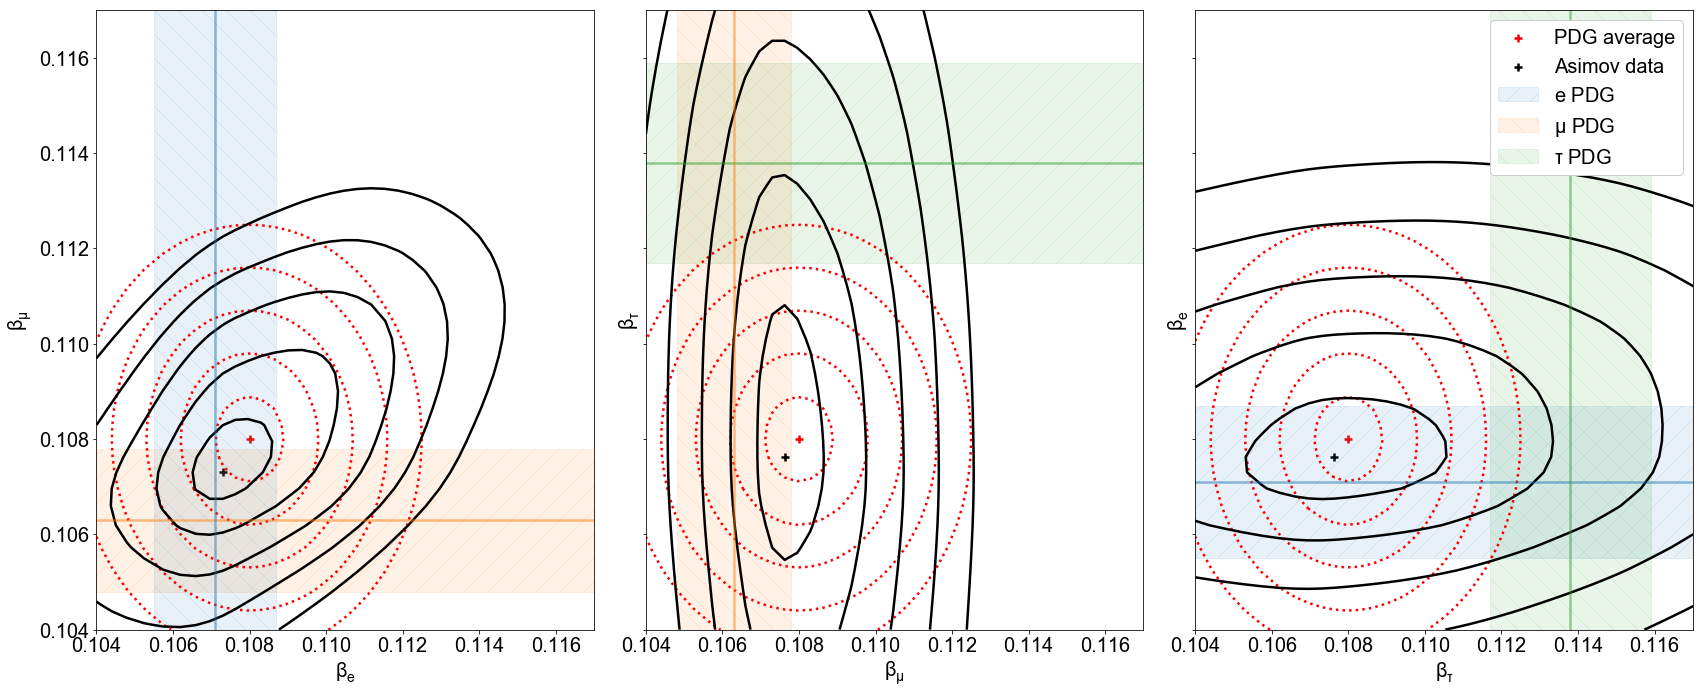

In [10]:
# plot the cost
fig, axes = plt.subplots(1, 3, figsize=(24, 10), facecolor='white', sharex = True, sharey=True)

# plot options
ninter = 5
grid_size = (8, 8)
scan_range = (0.104, 0.117)
clvls = [1, 4, 9, 16, 25]#, 36, 49, 64, 81, 100]

# configure data
imin = cost.argmin()
cost_min = cost.min()
beta_min = sv_accept[imin,:4]
#beta_min = [0.1052, 0.1067, 0.1159, 0.6722]

# PDG average
from scipy.stats import multivariate_normal
mu = 0.1080
sigma = 0.0009
f_pdg = multivariate_normal(mean=[mu, mu], cov=[[sigma**2, 0.], [0., sigma**2]])

# PDG exclusive BR
pdg_e = (0.1071, 0.0016)
pdg_mu = (0.1063, 0.0015)
pdg_tau = (0.1138, 0.0021)

# electron vs. muon
mask = (sv_accept[:,2] == beta_min[2])
X, Y = sv_accept[:,[0, 1]].T
X, Y = X[mask], Y[mask]
X, Y = zoom(X.reshape(grid_size), ninter), zoom(Y.reshape(grid_size), ninter)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y

nll_pdg = f_pdg.pdf(pos)
nll_pdg = -2*np.log(nll_pdg/nll_pdg.max())

cost_emu = zoom(cost[mask].reshape(grid_size), ninter) 
cost_emu -= cost_emu.min()
imin = cost_emu.argmin()
xmin = X[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]
ymin = Y[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]

ax = axes[0]
ax.scatter([mu], [mu], marker='+', c='r')
ax.scatter([xmin], [ymin], marker='+', c='k')
ax.fill_between(scan_range, 2*[pdg_mu[0] - pdg_mu[1], ], 2*[pdg_mu[0] + pdg_mu[1], ], color='C1', hatch='/', alpha=0.1)
ax.plot(scan_range, 2*[pdg_mu[0],], color='C1', alpha=0.5)
ax.fill_betweenx(scan_range, 2*[pdg_e[0] - pdg_e[1], ], 2*[pdg_e[0] + pdg_e[1], ], color='C0', hatch='\\', alpha=0.1)
ax.plot(2*[pdg_e[0],], scan_range, color='C0', alpha=0.5)
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='dotted', colors='r')
ax.contour(X, Y, cost_emu, levels=clvls, linestyles='solid', colors = 'k')
ax.set_xlim(scan_range)
ax.set_ylim(scan_range)
ax.set_xlabel(r'$\beta_{e}$')
ax.set_ylabel(r'$\beta_{\mu}$')

# muon vs. tau
mask = (sv_accept[:,0] == beta_min[0])
X, Y = sv_accept[:,[1, 2]].T
X, Y = X[mask], Y[mask]
X, Y = zoom(X.reshape(grid_size), ninter), zoom(Y.reshape(grid_size), ninter)

pos[:,:,0] = X
pos[:,:,1] = Y
nll_pdg = f_pdg.pdf(pos)
nll_pdg = -2*np.log(nll_pdg/nll_pdg.max())

cost_mutau = zoom(cost[mask].reshape(grid_size), ninter) 
cost_mutau -= cost_mutau.min()
imin = cost_mutau.argmin()
xmin = X[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]
ymin = Y[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]

ax = axes[1]
ax.scatter([mu], [mu], marker='+', c='r')
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='dotted', colors='r')
ax.fill_between(scan_range, 2*[pdg_tau[0] - pdg_tau[1], ], 2*[pdg_tau[0] + pdg_tau[1], ], color='C2', hatch='/', alpha=0.1)
ax.plot(scan_range, 2*[pdg_tau[0],], color='C2', alpha=0.5)
ax.fill_betweenx(scan_range, 2*[pdg_mu[0] - pdg_mu[1], ], 2*[pdg_mu[0] + pdg_mu[1], ], color='C1', hatch='\\', alpha=0.1)
ax.plot(2*[pdg_mu[0],], scan_range, color='C1', alpha=0.5)
ax.test(0.85, 0.9, r'$\beta_{tau} = 0.108$', transform=ax.T)

ax.scatter([xmin], [ymin], marker='+', c='k')
ax.contour(X, Y, cost_mutau, levels=clvls, linestyles='solid', colors = 'k')
ax.set_xlabel(r'$\beta_{\mu}$')
ax.set_ylabel(r'$\beta_{\tau}$')

# muon vs. tau
mask = (sv_accept[:,1] == beta_min[1])
X, Y = sv_accept[:,[2, 0]].T
X, Y = X[mask], Y[mask]
X, Y = zoom(X.reshape(grid_size), ninter), zoom(Y.reshape(grid_size), ninter)

pos[:,:,0] = X
pos[:,:,1] = Y
nll_pdg = f_pdg.pdf(pos)
nll_pdg = -2*np.log(nll_pdg/nll_pdg.max())

cost_etau = zoom(cost[mask].reshape(grid_size), ninter) 
cost_etau -= cost_etau.min()
imin = cost_etau.argmin()
xmin = X[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]
ymin = Y[imin//(ninter*grid_size[0]), imin%(ninter*grid_size[0])]

ax = axes[2]
ax.scatter([mu], [mu], marker='+', c='r', label='PDG average')
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='dotted', colors='r')

ax.scatter([xmin], [ymin], marker='+', c='k', label='Asimov data')
ax.contour(X, Y, cost_etau, levels=clvls, linestyles='solid', colors = 'k', label='2016 data')

ax.plot(scan_range, 2*[pdg_e[0],], color='C0', alpha=0.5, label='_nolegend_')
ax.fill_between(scan_range, 2*[pdg_e[0] - pdg_e[1], ], 2*[pdg_e[0] + pdg_e[1], ], color='C0', hatch='/', alpha=0.1, label=r'$e$ PDG')

# dummy plot to add mu to legend
ax.fill_betweenx([0., 0.], 2*[pdg_mu[0] - pdg_mu[1], ], 2*[pdg_mu[0] + pdg_mu[1], ], color='C1', hatch='\\', alpha=0.1, label=r'$\mu$ PDG')

ax.plot(2*[pdg_tau[0],], scan_range, color='C2', alpha=0.5, label='_nolegend_')
ax.fill_betweenx(scan_range, 2*[pdg_tau[0] - pdg_tau[1], ], 2*[pdg_tau[0] + pdg_tau[1], ], color='C2', hatch='\\', alpha=0.1, label=r'$\tau$ PDG')

ax.set_xlabel(r'$\beta_{\tau}$')
ax.set_ylabel(r'$\beta_{e}$')
ax.legend(loc=1, framealpha=1.)

plt.tight_layout()
plt.savefig('plots/result_contours_test.pdf')
plt.savefig('plots/result_contours_test.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='white')

fnorm = multivariate_normal(0, 1)
x = np.linspace(-5, 5, 1e3)
ax.plot(x, -2*np.log(fnorm.pdf(x)/fnorm.pdf(0)), 'k--')
ax.set_xlim(-5, 5)
ax.set_ylim(0, None)
ax.grid()

plt.show()